## Home Assignment 3

Submit your solution via Moodle until 23.59pm on Wednesday, December 18th. Late submissions are accepted for 12 hours following the deadline, with 1/3 of the total possible points deducted from the score.

Submit your solutions in teams of up 2-3 members. **Single student submissions will not be graded anymore**.
Please denote all members of the team with their student ID and full name in the notebook. In this home assignment, you have to submit an .ipynb notebook and a file "labels.npy" as specified in task 3. Do not submit anything else than these two files!

Cite ALL your sources for coding this home assignment. In case of plagiarism (copying solutions from other teams or from the internet) ALL team members will be expelled from the course without warning.

##### List team members, including all student IDs here:
1. Romayssa Bedjaoui 402197
2. Moncef Benaicha 403758

In [16]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB

### Task 1: Fair Classification with the Two Naive Bayes Algorithm (2 pts)

Recall the _Ricci_ dataset that we have discussed in lecture, which shows the results of an exam for promotion eligibility. For the purpose of this exercise, we want to build a classifier which achieves that the group that gets a promoted (_Class_ attribute) is fairly balanced with respect to the sensitive attribute *Race* - as noted in lecture, enforcing this equality on that data has actually caused a "reverse discrimination" lawsuit. The majority class, i.e. the white population, has sensitive attribute value 1, and all non-whites have sensitive attribute value 0.

The dataset is read in the cell below, and an implementation of the CV measure can also be found below that. Note that in the following tasks, you should make use of functions from scikit-learn whereever possible.

In [17]:
df = pd.read_csv("ricci.csv")
df.head()

,Oral,Written,Race,Combine,Class,Position_Captain,Position_Lieutenant
0,89.52,95,1,92.808,1,1,0
1,80.00,95,1,89.000,1,1,0
2,82.38,87,1,85.152,1,1,0
3,88.57,76,1,81.028,1,1,0
4,76.19,84,1,80.876,1,1,0


In [18]:
def cv_measure(y_pred, s_arr):
    pos_mask = s_arr==1
    neg_mask = s_arr==0

    return 1.0 - np.sum(y_pred[pos_mask])/np.sum(pos_mask) + np.sum(y_pred[neg_mask])/np.sum(neg_mask)

#### a) Biased Classification (0.5 pts)

Train a Gaussian Naive Bayes classifier on the full dataset which learns to predict the _Class_ attribute using all other columns in the data. Apply your model on the training data, and compute the CV score of the resulting predictions with respect to the sensitive attribute _Race_. What does the result say on the disparity in the classifications of each majority and minority group?

In [19]:
#Train the whole dataset in Gaussian Naive Bayes Classifier
inputs=df.drop(columns='Class').values
output=df["Class"]
clf = GaussianNB()
clf.fit(inputs, output)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
#Applying the model on the training data
y_predict=clf.predict(inputs)
print("CV_measure of the Learning Model:  ", round(cv_measure(y_predict,df["Race"]),3))

CV_measure of the Learning Model:   0.534


The CV measure shows that our model misclasifies our sensitive attribute "Race" as the value is far from 1 and 1 means that it is fairly classified.

The conclusion: The classifcation among the two groups (different Race: 0 and 1) are not balanced, so one group is not fairly classified. 

#### b) Applying Two Naive Bayes Models (0.5 pts)

Train two different Naive Bayes Models, one for each of the two race values. Again, apply these on the data samples that corresponds to the population they were trained on, and combine their predictions. Are the classifications among both population groups more balanced?

In [21]:
#Model 1
df_1=df[df["Race"]==1]
df_0=df[df["Race"]==0]
inputs_1=df_1.drop(columns='Class').values
output_1=df_1["Class"]

#Model 2
inputs_0=df_0.drop(columns='Class').values
output_0=df_0["Class"]
clf = GaussianNB()
clf_1=clf.fit(inputs_1, output_1)
clf_0=clf.fit(inputs_0, output_0)

In [22]:
y_pred_1=clf_1.predict(inputs_1)
y_pred_0=clf_0.predict(inputs_0)

In [23]:
y_pred_fair=np.concatenate((y_pred_1, y_pred_0), axis=0)
print(cv_measure(y_pred_fair,df["Race"]))

0.8423529411764705


The classifications among both population groups is definitely more balanced by fitting two different models. But still there is a group which is not fairly classified as the other.

#### c) The Two Naive Bayes Algorithm by Calders and Verwer (1 pt)

In lecture we have briefly touched the Two Naive Bayes algorithm by Calders and Verwer. Its main idea is to train two different Naive Bayes models corresponding to both values of a binary sensitive attribute $S$, and to then adapt the prior probabilities $P(Y|S)$ of each of these models until the predictions on the training data become fair.
More precisely, in training, we first fit two different models, namely one for the privileged class $S=1$ and one for the non-privileged class $S=0$, to obtain the conditional probabilities $P(X_i|Y,S=s)$, $s=0,1$, and the priors $P(Y|S=s)$, $s=0,1$ from the training data. After these initial fits, we evaluate the model on the training data, and if we do not observe fair predictions, i.e. predictions for which the CV score is at least $1-\epsilon$ for some $\epsilon>0$, we adapt the priors $P(Y|S=s)$ until this is the case. This adaptation is carried out as follows:

We initialize $N(Y=j, S=s)$ as the number of training samples with class $j$ and sensitive attribute value $s$, and $N(Y=1)$ the number of samples with class $1$ in the data. Further, let $\Delta$ denote an adaptation rate, which is given as input.  
Then we conduct the following iteration:

     cv_score <- CV score of the predicted classes by the current model.
     while cv_score < 1 - \epsilon:
        n_pos <- number of predicted positive samples from the current model.
        if n_pos < N(Y=1):
           N(Y=1, S=0) <- N(Y=1, S=0) + ΔN(Y=0, S=1)
           N(Y=0, S=0) <- N(Y=0, S=0) - ΔN(Y=0, S=1) 
        else:
           N(Y=0, S=1) <- N(Y=0, S=1) + ΔN(Y=1, S=0)
           N(Y=1, S=1) <- N(Y=1, S=1) - ΔN(Y=1, S=0)
        if any of the N(Y, S) is negative then cancel the previous update of N(Y, S) and abort
        Recalculate priors P(Y|S=i)  and cv_score based on updated N(Y, S)
    
Note that the priors $P(Y|S=s)$ are calculated via
$$P(Y|S=s) = \frac{N(Y, S=s)}{N(S=s)},$$
where $N(S=s)$ denotes the number of samples in the data with sensitive attribute value $s$.

**Task description:** Implement a class that runs the Two Naive Bayes algorithm, using the signatures in the cell below! Apply Gaussian Naive Bayes models to fit your data. In particular, you do not need to differentiate between continuous and discrete data as in home assignment 2, and you can use the GaussianNB class from sklearn to fit the two individual models. Note that this class also has an attribute that stores the prior probabilities and can be overwritten easily.
Further, you may assume that all input data is valid, i.e. you do not need to check whether for instance the feature matrix X has as many rows as the class vector y or the sensitive attribute vector s_arr.

Apply your implementation on the Ricci dataset with default values for $\epsilon$ and $\Delta$, and compute the resulting CV score.

In [24]:
import numpy as np
from sklearn.naive_bayes import GaussianNB


class TwoNaiveBayes:
    clf_1 = GaussianNB()
    clf_0 = GaussianNB()

    # delta: adaptation rate (float)
    # eps: fairness tolerance, we consider a classification fair if the cv score on the training data is at least 1 - eps
    def __init__(self, delta=0.01, eps=0.05):
        # your code here
        self.delta = delta
        self.eps = eps

    # X: 2d numerical numpy array reprenting the feature matrix without the sensitive attribute
    # s_arr: binary 1D numpy array representing the sensitive attribute
    # y: binary 1D numpy array representing the class labels to train on
    #
    # nothing is returned, only internal parameters are being fit
    def fit(self, X, s_arr, y):
        # We will fit two different model
        data = pd.DataFrame(X)
        data["s_arr"] = s_arr
        data["Y"] = y

        data_0 = data[data["s_arr"] == 0]
        inputs_0 = data_0.drop(columns='Y').values
        output_0 = data_0["Y"]

        data_1 = data[data["s_arr"] == 1]
        inputs_1 = data_1.drop(columns='Y').values
        output_1 = data_1["Y"]

        self.clf_1.fit(inputs_1, output_1)
        self.clf_0.fit(inputs_0, output_0)

        # Init
        y_pred_1 = self.clf_1.predict(inputs_1)
        y_pred_0 = self.clf_0.predict(inputs_0)

        # Initialisation of the CV_score
        y_pred_0_1 = np.concatenate((y_pred_0,y_pred_1), axis=0)
        cv_score = cv_measure(y_pred_0_1, data["s_arr"])
        print("First CV_Score", cv_score)

        # initialisation of numbers
        nbr_0_0 = data_0[data_0['Y'] == 0].shape[0]
        
        nbr_0_1 = data_0[data_0['Y'] == 1].shape[0]

        nbr_1_0 = data_1[data_1['Y'] == 0].shape[0]
        nbr_1_1 = data_1[data_1['Y'] == 1].shape[0]

        Nbr_y_1 = data[data["Y"] == 1].shape[0]

        while cv_score < (1 - self.eps):
            n_pos = y_pred_0_1.sum()

            if n_pos < Nbr_y_1:
                # print("update if 1")
                if (nbr_1_0 + self.delta * nbr_0_1) < 0:
                    break
                else:
                    nbr_1_0 = nbr_1_0 + self.delta * nbr_0_1
                if (nbr_0_0 - self.delta * nbr_0_1) < 0:
                    break
                else:
                    nbr_0_0 = nbr_0_0 - self.delta * nbr_0_1

            else:
                # print("update if 2")
                if (nbr_0_1 + self.delta * nbr_1_0) < 0:
                    break
                else:
                    nbr_0_1 = nbr_0_1 + self.delta * nbr_1_0
                # print(nbr_0_1)

                if (nbr_1_1 - self.delta * nbr_1_0) < 0:
                    break
                else:
                    nbr_1_1 = nbr_1_1 - self.delta * nbr_1_0
                # print(nbr_1_1)

            # Updating priors of the two models

            # Race 0
            p_0_0 = nbr_0_0 / (nbr_0_0 + nbr_0_1)
            p_0_1 = nbr_0_1 / (nbr_0_0 + nbr_0_1)
        
            self.clf_0.class_prior_ = [p_0_0, p_0_1]

        
            # Race 1
            p_1_0 = nbr_1_0 / (nbr_1_0 + nbr_1_1)
            p_1_1 = nbr_1_1 / (nbr_1_0 + nbr_1_1)

            
            self.clf_1.class_prior = [p_1_0, p_1_1]
        
            # Recalculating the CV_score
            y_pred_0 = self.clf_0.predict(inputs_0)
            y_pred_1 = self.clf_1.predict(inputs_1)

            y_pred_0_1 = np.concatenate((y_pred_0, y_pred_1), axis=0)
            cv_score = cv_measure(y_pred_0_1,data["s_arr"] )
        print("Last cv_score for the most fair predection\n----------",cv_score,"------------")

    # X: 2d numerical numpy array reprenting the feature matrix without the sensitive attribute
    # s_arr: binary 1D numpy array representing the sensitive attribute to consider when predicting
    #
    # return binary numpy array vector of fair class labels
    def predict(self, X, s_arr):
        # your code here
        data = pd.DataFrame(X)
        data["s_arr"] = s_arr
        inputs_0 = data[data["s_arr"] == 0]
        inputs_1 = data[data["s_arr"] == 1]
        y_pred_1 = self.clf_1.predict(inputs_1)
        y_pred_0 = self.clf_0.predict(inputs_0)

        # returning the fair prediction
        return np.concatenate((y_pred_1, y_pred_0), axis=0)



### <Center>EXEMPLE TO SHOW THE IMPLEMENTATION OF THE TWONAIVEBAYES CLASS </center>

In [25]:
model=TwoNaiveBayes()
data= df
s_arr=df["Race"].values
Y=df["Class"].values
colu=["Class","Race"]
X=df.drop(columns=colu).values
model.fit(X, s_arr, Y)

First CV_Score 0.8852941176470589
Last cv_score for the most fair predection
---------- 0.9105882352941177 ------------


### CONCLUSION

This implementation of the class TwoNaiveBayes improves the fairness of the classification of our sensitive attribute Race. 

There is a huge difference between the first obtained CV_score and the one with this method: from 0.534 to 0.9105. This implementation performs also better than when we only train two different models: 0.88 and 0.91.

In [26]:
print("-------------Fair prediction of the Dataset------------")
model.predict(X,s_arr)

-------------Fair prediction of the Dataset------------


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

###  Task 2: k-Means Clustering (1.5 pts)

We want to apply the $k$-means clustering algorithm from lecture to assign clusters to the dataset in "clusters.txt", which is loaded and plotted in the cell below.

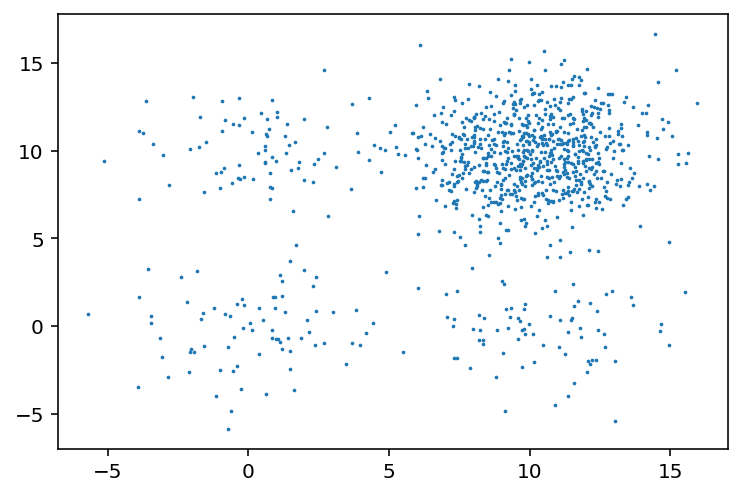

In [7]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

X = np.loadtxt("clusters.txt")
plt.scatter(X[:,0],X[:,1], s=0.7)
plt.show()

#### a) Implementing k-means (0.75 pts)

Implement the $k$-means clustering algorithm using the function specification in the cell below.

In [28]:
import numpy as np
import pandas as pd

# INPUT VALUES:
# X: numerical 2D numpy array, each row is a sample
# k: int, number of clusters, ignored if init_points is not None
# init_points: list of row indices which indicate the data points that the clusters are initialized with
# -> default is None, indicating that random data points are initialized as cluster centers
# if specified, k is chosen as the number of cluster centers, and input for k is ignored
#
# RETURN:
# y: vector with cluster labels in {1,...,k}


def update_centroid(data, k):
    centroid = {
        i: [np.mean(data[data["class"] == i]["x"]),
            np.mean(data[data["class"] == i]["y"])] for i in range(k)
    }
    return centroid


def update_attribution(data, centroid):
    d_columns = []
    for key in centroid.keys():
        d_key = "distance-"+str(key)
        data[d_key] = (np.sqrt(
            (data["x"]-centroid[key][0])**2 + (data["y"]-centroid[key][1])**2
        ))
        d_columns.append(d_key)
    data["class"] = data.apply(lambda row: np.argmin(row[d_columns].values), axis=1)
    for k in centroid.keys():
        del data["distance-"+str(k)]
    return data


def tot_within(data, centroid):
    out = []
    for key in centroid.keys():
        out.append(np.sum((data[data["class"]==key]["x"]-centroid[key][0])**2 + (data[data["class"]==key]["y"]-centroid[key][1])**2))
    return np.sum(out)


def k_means(X, k=2, init_points=None):
    ## your code here
    if init_points:
        k = len(init_points)
    data = pd.DataFrame(data=X, columns=["x", "y"])
    data["class"] = [np.random.choice(k, 1)[0] for _ in range(data.shape[0])]
    if init_points:
        centroid = {
            i: [data["x"].iloc[j], data["y"].iloc[j]] for i, j in enumerate(init_points)
        }
    else:
        centroid = update_centroid(data, k)
    tw_o = tot_within(data, centroid)
    for i in range(10):
        data = update_attribution(data, centroid)
        centroid = update_centroid(data, k)
        tw_n = tot_within(data, centroid)
        if tw_o == tw_n:
            break
        tw_o = tw_n
    return data["class"]

#### b) Application with random initialization (0.25 pts)

Apply your implementation 10 times on the data from clusters.txt, choosing $k = 4$ and random initalization of cluster centers. For each run, scatterplot the data as above, with different colors indicating the clusters.

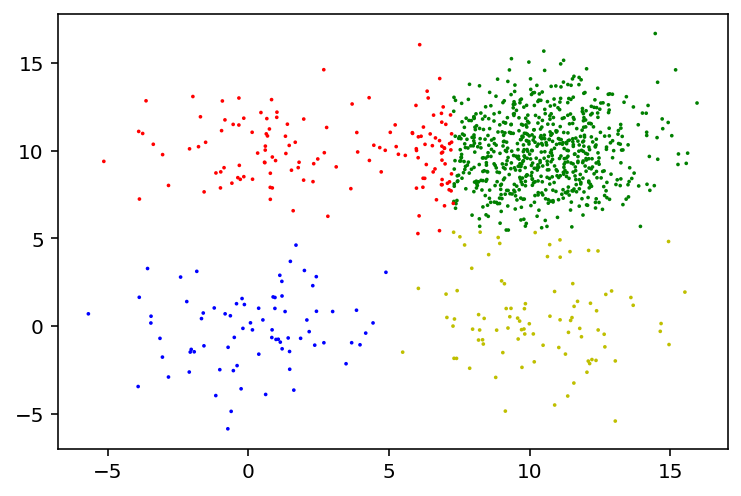

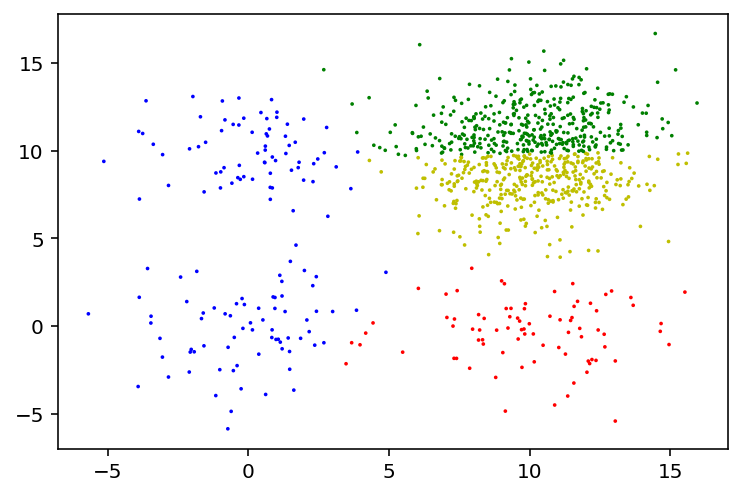

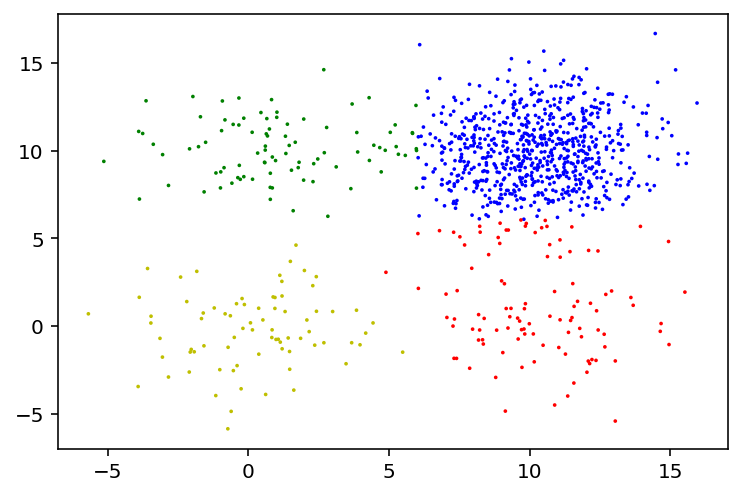

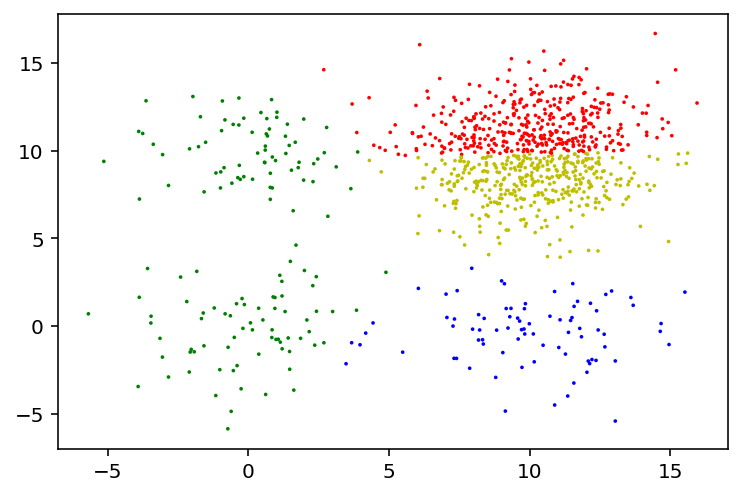

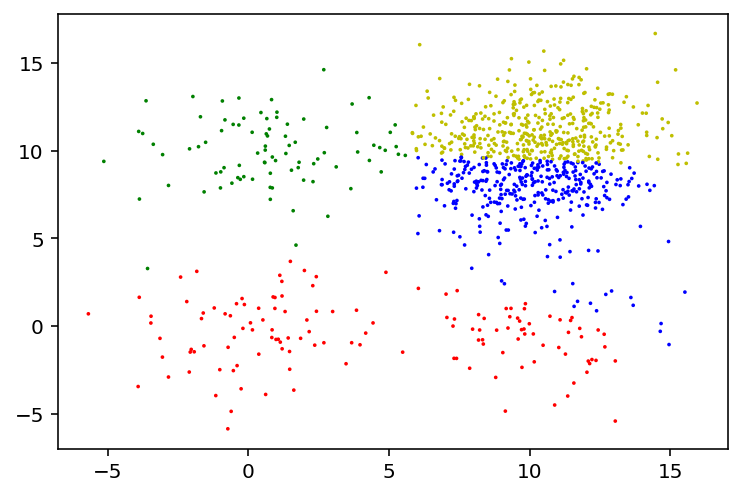

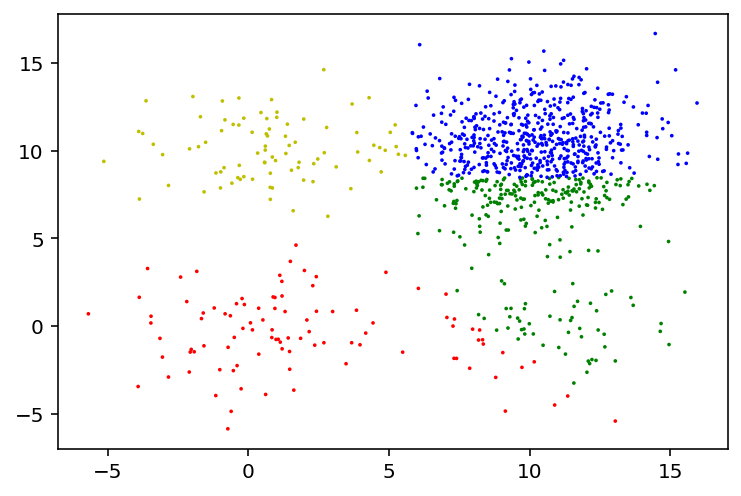

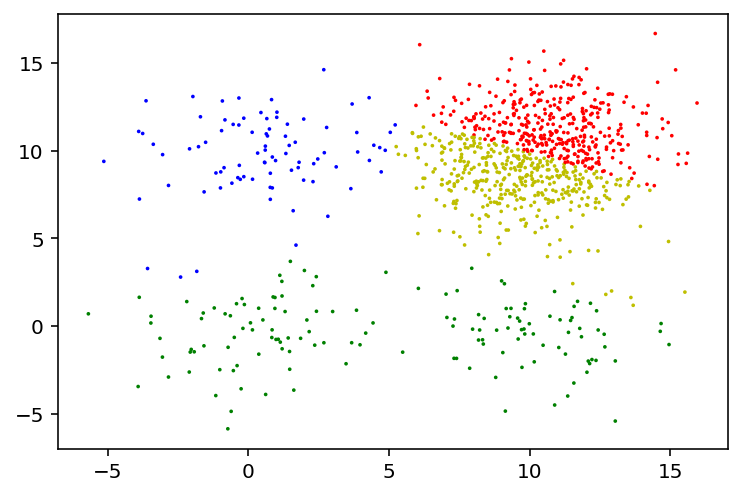

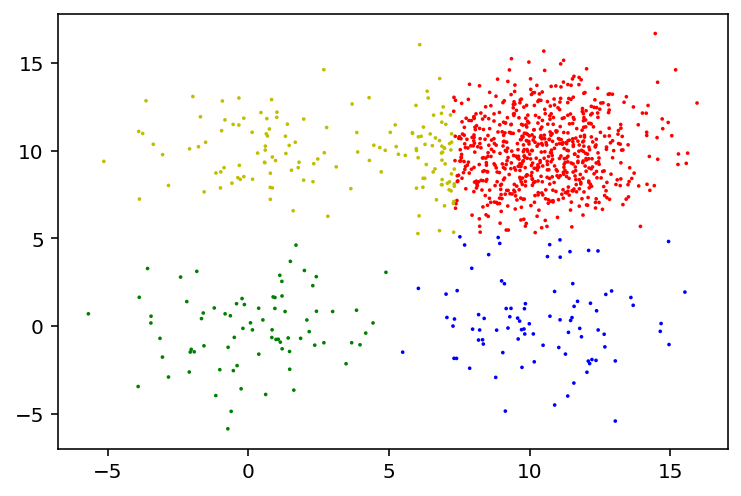

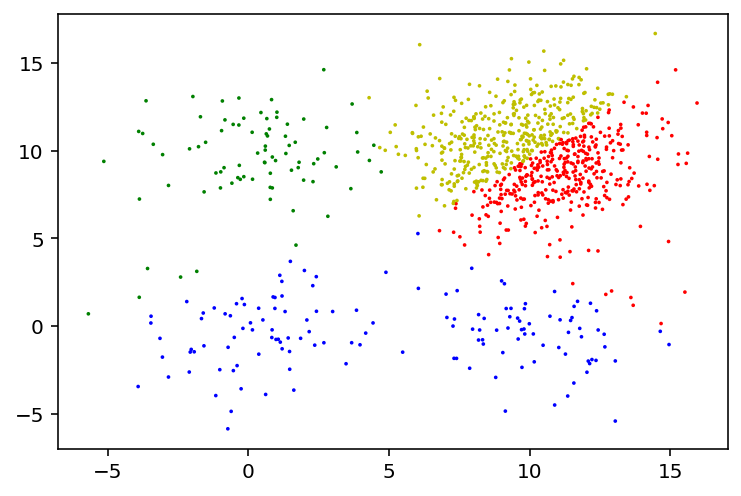

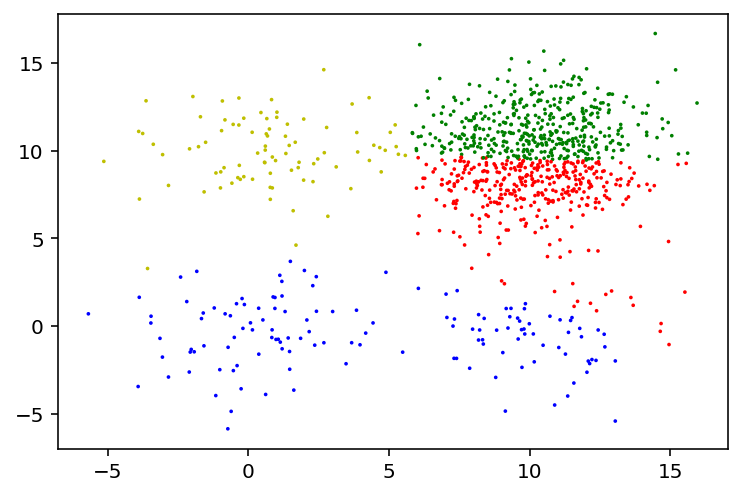

In [29]:
colormap = {
    0:"r",1:"b",2:"y",3:"g"
}
for i in range(10):
    classes = k_means(X,k=4)
    label_color = [colormap[l] for l in classes]
    plt.scatter(X[:,0],X[:,1], s=0.7, c=label_color)
    plt.show()

#### c) k-means++ (0.5 pts)

Recall the initialization of cluster centers from the $k$-means++ algorithm as presented in lecture:

Let $X$ the set of data points, and $\mathcal{D}(x)$ denote the shortest distance from a data point to the closest center we have already chosen. Then, the k-means++ initialization consists of the following steps.
1. Take one center $c_1$, chosen uniformly at random from $X$.
2. Take a new center $c_i$, choosing $x \in X$ with probability $$p(x) = \frac{D(x)^2}{\sum_{x\in X} D(x)^2}.$$
3. Repeat Step 2 until we have taken $k$ centers altogether.

Implement this initialization, using the signature in the cell below. Use Euclidean distance to measure distance between any pair of points in the data.  
Apply this initialization to rerun the experiment from b). That is, run the $4$-means clustering algorithm ten times on the given data, using the initialization from k_means_pp, and scatterplot each clustering using different colors for different clusters. 

In [1]:
# INPUT VALUES:
# X: numerical 2D numpy array, each row is a sample
# k: int, number of clusters, ignored if init_points is not None
#
# RETURN:
# init_points: list of row indices which indicate the data points that the clusters are initialized with
from sklearn.metrics import pairwise_distances

def distance(X1,X2):
    X1 = X1.reshape(1, -1)
    X2 = X2.reshape(1, -1)
    #return pairwise_distances(X1, X2, metric='euclidean')
    return np.sqrt(np.sum(X1-X2)**2)

def init_k_means_pp(X,k):
    # your code here
    init_points = []
    init_points.append(np.random.randint(0,X.shape[0],size=1)[0])
    for c in range(k-1):
        dist = []
        for row in X:
            d = distance(row,X[init_points[0],:])
            for j in range(1,len(init_points)):
                d = min(d,distance(row,X[init_points[j],:]))
            dist.append(d)
        proba = [d**2/sum(dist) for d in dist]
        init_points.append(np.argmax(proba))
    return init_points

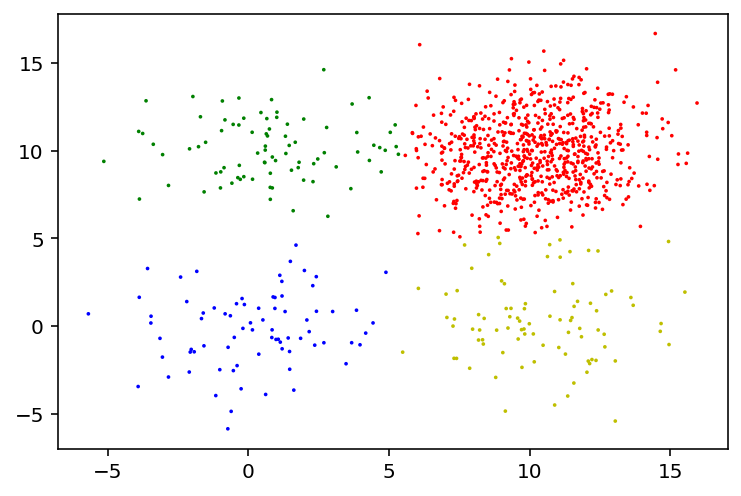

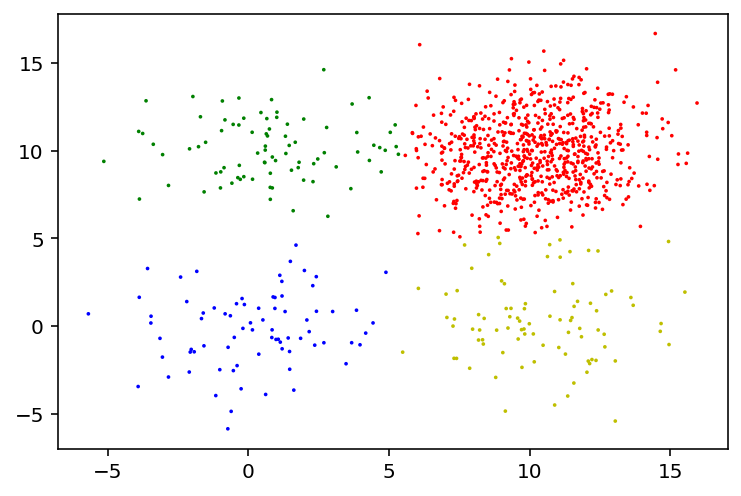

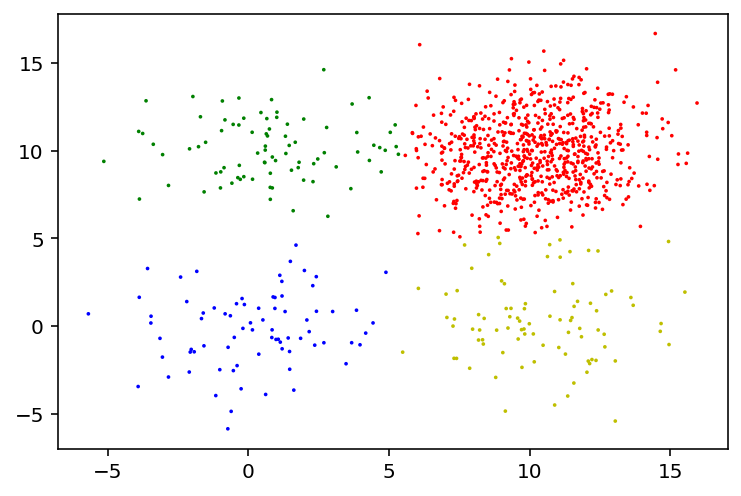

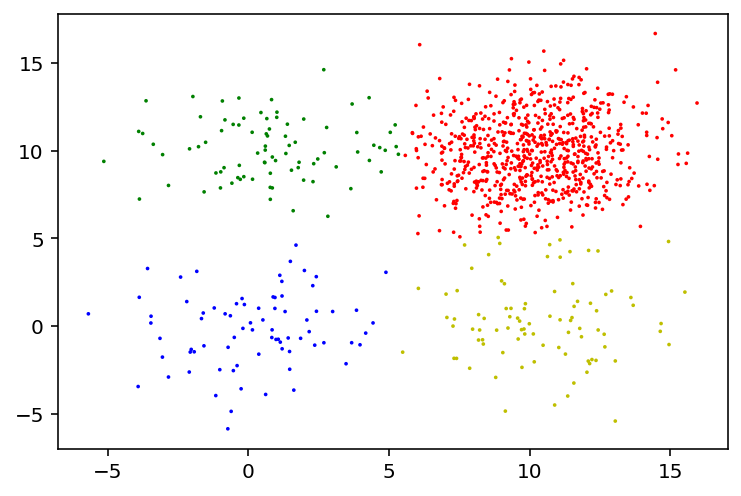

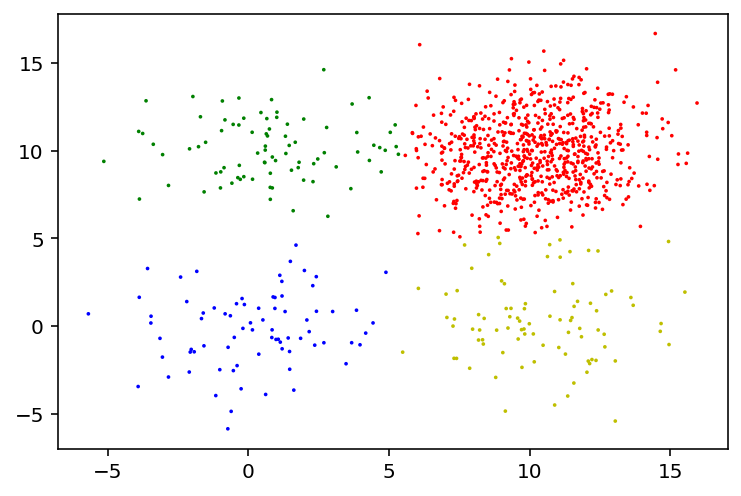

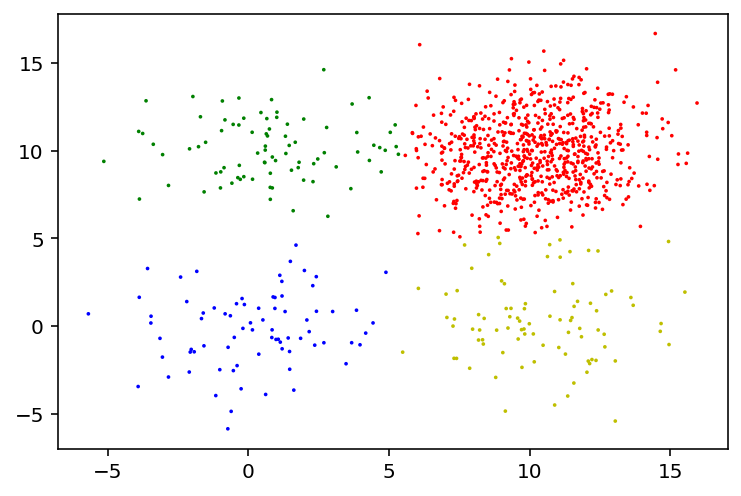

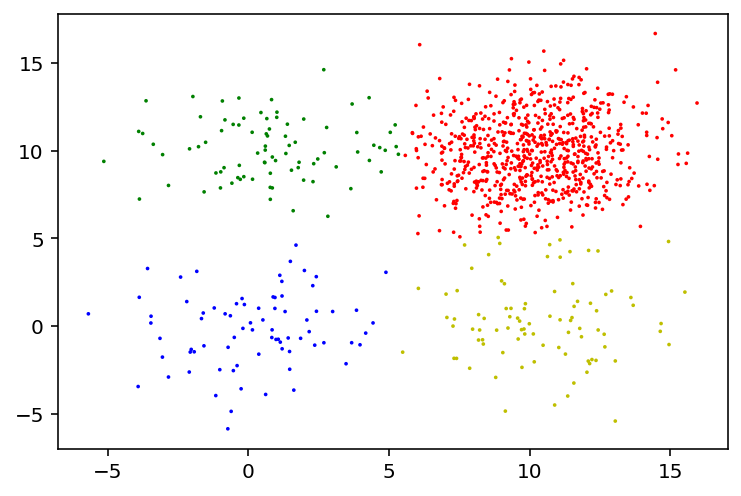

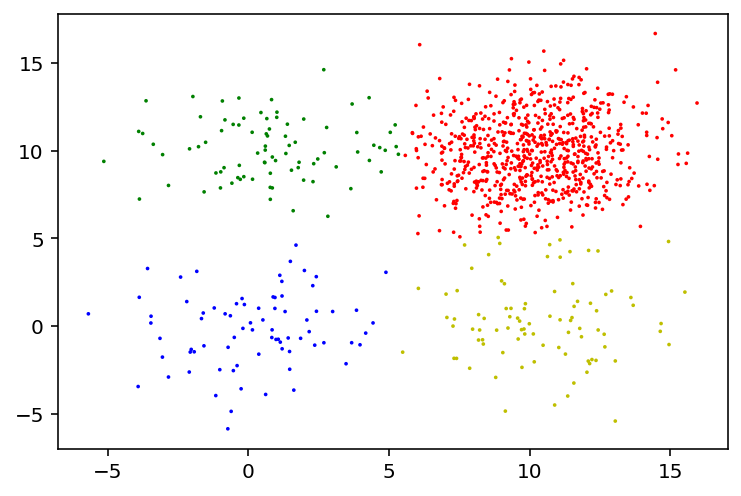

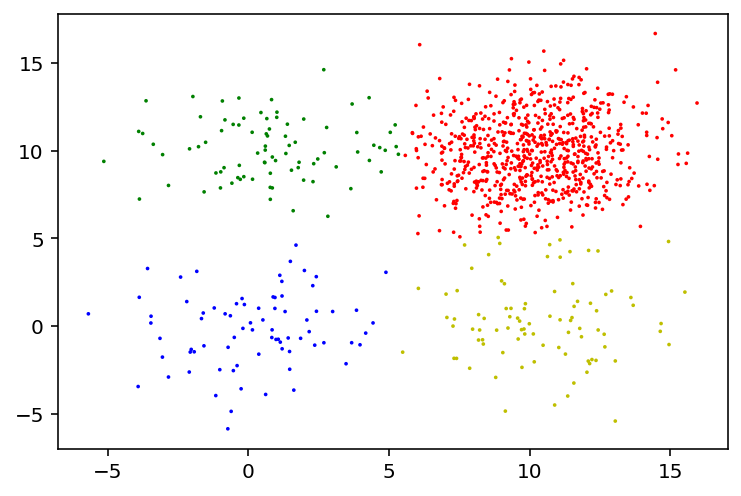

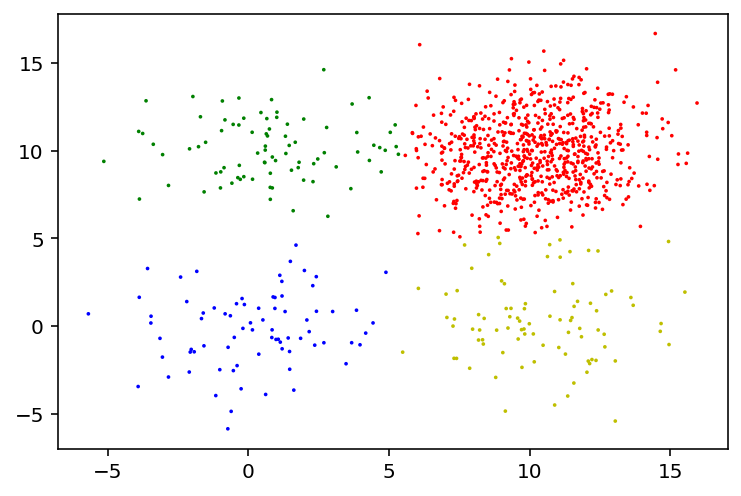

In [31]:
init_p = init_k_means_pp(X,4)
colormap = {
    0:"r",1:"b",2:"y",3:"g"
}
for i in range(10):
    classes = k_means(X,init_points=init_p)
    label_color = [colormap[l] for l in classes]
    plt.scatter(X[:,0],X[:,1], s=0.7, c=label_color)
    plt.show()

### Task 3: Helping Santa (1.5 pts)

Santa Claus has gotten old and cannot deliver the christmas presents by himself anymore. Luckily, he has his team of 20 elves that are happy to carry all the presents out for him.
To distribute presents in an efficient way, he wants to partition the households to deliver presents to in an optimal way, by clustering the locations that the presents are delivered to.
A map with the coordinates of each household to deliver can be found in "xmas.txt", and it is loaded and plotted in the cell below.

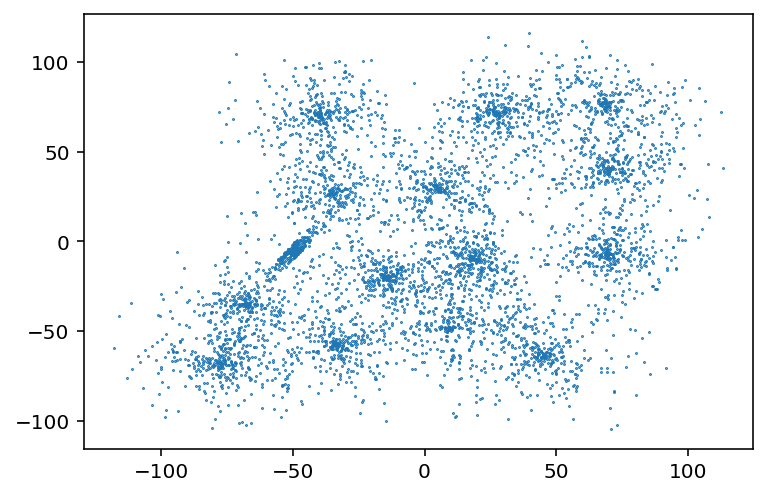

In [8]:
xmas = np.loadtxt("xmas.txt")
plt.scatter(xmas[:,0],xmas[:,1], s=0.2)
plt.show()

#### a) The Silhouette Coefficient (0.5 pts)

Since santa cannot judge the quality of a clustering by looking at a map, he needs to apply some quality measure that quantifies how good a clustering is.  

One such measure, which both evaluates how compact clusters are among themselves, and how well different clusters are separated, is the **silhouette coefficient**.
Assuming that all data points $x_1,\dots ,x_n$ are partitioned into $k$ clusters $C_1, \dots, C_k$, we can compute two coefficients for each data point $x_i$. On the one hand, assuming that $x_i \in C_l$,
$$
a(x_i) := \frac{\sum_{x_j\in C_l} d(x_i,x_j)}{|C_l| - 1}
$$
measures the compactness of the cluster $C_l$ to which $x_i$ belongs, and 
$$
b(x_i) := \min_{C_m\not= C_l}\left\{ \frac{\sum_{x_j\in C_m} d(x_i,x_j)}{|C_m|} \right\}
$$
captures the degree to which $x_i$ is separated from other clusters. Note that in these formulas, $d$ represents a distance function that can be chosen individually for the application at hand.
From these two values, we can compute the silhouette coefficient of $x_i$ via
$$
s(x_i) = \frac{b(x_i) - a(x_i)}{\max\{a(x_i),b(x_i)\}}.
$$
Note that the value of this coefficient lies between -1 and 1, with 1 being the optimum, and negative values indicating a bad clustering, where on expectation $x_i$ is further away from the data points in its own cluster than from points in any other cluster.  
To evaluate the quality of the **full clustering** of a dataset, one can then compute the **average silhouette coefficient of all points in a dataset**.  
Note that this measure does not require a fixed $k$, unlike the objective function in the k-means clustering algorithm, and thus it can also be used to find an optimal $k$.

Write a function that computes this silhouette score of a full clustering, using the _Euclidean distance_ as the distance function $d$. Use the signature which is specified in the cell below!

In [9]:
# INPUT VALUES
# X: numerical 2D numpy array, each row is a data sample
# y: numpy vector with corresponding cluster labels
#
# return value: single float


def a(xi,X,cur_class,classes):
    dist = []
    sub_X = X[np.argwhere(classes==cur_class),:]
    for xj in sub_X:
        if not np.array_equal(xi,xj):
            dist.append(distance(xi,xj))
    return np.mean(dist)

def b(xi,X,cur_class,classes):
    b = []
    for cj in [c for c in set(classes) if c!=cur_class]:
        dist = []
        sub_X = X[np.argwhere(classes==cj),:]
        for xj in sub_X:
            dist.append(distance(xi,xj))
        b.append(np.mean(dist))
    return min(b)


def silhouette_score(X,y):
    # your code here
    data = np.concatenate((X,np.array([y]).T),axis=1)
    s = []
    for row in data:
        ai = a(row[:2],data[:,:2],row[2],data[:,2])
        bi = b(row[:2],data[:,:2],row[2],data[:,2])
        s.append((bi-ai)/max(ai,bi))
    return np.mean(s)

#### b) Finding the Optimal Hierarchical Clustering (1 pt)

On christmas eve, Santa wants to send an appropriate number of his elves out to deliver all the presents, and he wants to send at least 10 elves out, because the limited capacity of their sleighs does not allow for a smaller number. However, he is also fine with not sending all of his 20 elves out, since all the elves that are not delivering presents could prepare Santa's own traditional christmas party in the meantime.  
Thus, he decides to simply send out the number of elves between 10 and 20 that yields the best clustering with respect to the silhouette score. Since santa does not like the risks of random initializations, he wants to apply a hierarchical clustering algorithm for that task.

Find the optimal clustering of the households on the christmas map consisting of between 10 and 20 clusters, resulting from a hierarchical (agglomerative) clustering with either single, average or complete linkage, and using Euclidean distance. Save the corresponding vector of optimal cluster labels into a file "labels.npy" and submit this file along with your noteboook. Also provide all code that you used to find this optimum in the cell(s) below.    
Note that you do not need to implement hierarchical clustering yourself, but may resort to popular python libraries.
Also note that this task is not a class competition, it is only about applying the clustering algorithms and measures correctly.

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score as sk_silhouette_score
affinity = "euclidean"
score = {"ward":{},"complete":{},"average":{},"single":{}}
for linkage in score.keys():
    for k in range(10,21):
        mycluster = AgglomerativeClustering(n_clusters=k,affinity=affinity,linkage=linkage)
        mycluster.fit(X)
        labels = mycluster.labels_
        score[linkage][k] = {"labels":labels ,"score": sk_silhouette_score(X,labels)}

In [12]:
from prettytable import PrettyTable
for linkage in score.keys():
    print('*'*30+' '+linkage+' '+'*'*30)
    t = PrettyTable(['k', 'score'])
    for k in score[linkage].keys():
        t.add_row([k, score[linkage][k]["score"]])
    print(t)

****************************** ward ******************************
+----+---------------------+
| k  |        score        |
+----+---------------------+
| 10 | 0.34435569963891766 |
| 11 |  0.326454348990374  |
| 12 |  0.3179789961845862 |
| 13 | 0.31488433593653087 |
| 14 |  0.3011872578231068 |
| 15 | 0.30022451608025374 |
| 16 |  0.2944979895360774 |
| 17 |  0.2963064597937023 |
| 18 | 0.29803391249376365 |
| 19 | 0.27692366831272164 |
| 20 | 0.27740478901463017 |
+----+---------------------+
****************************** complete ******************************
+----+---------------------+
| k  |        score        |
+----+---------------------+
| 10 |  0.2372407682150588 |
| 11 | 0.23884634226791257 |
| 12 | 0.23562515385118632 |
| 13 | 0.24572393580093638 |
| 14 | 0.23870321414225065 |
| 15 | 0.23666668549088732 |
| 16 | 0.24045868485962837 |
| 17 | 0.23849035862280193 |
| 18 | 0.28346375715286776 |
| 19 | 0.29243194847015086 |
| 20 |  0.2933509735013375 |
+----+---------------

<b>The best score is 0.34 with k=10 and linkage method is ward.</b>

In [18]:
#np.save("labels",score["ward"][10]["labels"])
